In [ ]:
#Загрузка файла с табличными данными
!wget https://www.dropbox.com/s/2yjaru8mbkeynwe/dataset%20%283%29.csv?dl=1 -O dataset.csv

In [1]:
#Импортирование необходимых библиотек для обработки и чтение файла с табличными данными
import cv2
import os
import numpy as np
import shutil
import torch
import zipfile
import cv2
import os
import numpy as np
import pandas as pd
import datetime as dt
dataset = pd.read_csv('dataset_prefin.csv')
dataset_temp = pd.read_csv('dataset.csv')

In [2]:
dataset['video_popularity'] = dataset_temp['pop_score']
dataset['video_duration'] = dataset_temp['video_duration']

In [ ]:
preds = []
import torchvision.models
import torchvision.transforms as transforms
model = torchvision.models.resnet50()
model.fc = torch.nn.Linear(in_features=2048, out_features=1)
model = model.cuda()
device = 'cuda'
model.load_state_dict(torch.load('model-resnet50.pth', map_location=device))
transform_train_img = transforms.Compose([transforms.Resize([224, 224]),
transforms.ToTensor()])
from PIL import Image
preds = []
model.eval().cuda()
i = 0
for image in dataset['review']:
    i+=1
    print(i)
    image = Image.open(os.path.join('images-2/images-2', image))
    image = transform_train_img(image)
    image = image.unsqueeze(0)
    image = image.cuda()
    with torch.no_grad():
        score = model(image)
        preds.append(score)
for i in range(len(preds)):
    preds[i] = preds[i].item()
dataset['pop_score'] = preds

In [3]:
dataset = dataset.rename(columns={"view_count": "view_count_prev", "like_count": "like_count_prev", "dislike_count":"dislike_count_prev", "comment_count":"comment_count_prev" })

In [4]:
#Обработка временных показателей даты загрузки видео на видеохостинг и даты создания канала.
dataset['Time_cur'] = pd.to_datetime(dataset['published_at'])
dataset['published_hour_cur'] = dataset['Time_cur'].dt.hour
dataset['Weekday_cur'] = dataset['Time_cur'].dt.weekday
diff = dt.datetime.now() - dataset['Time_cur']
dataset['Published_diff_time'] = (dt.datetime.now() - dataset['Time_cur']).dt.total_seconds()
dataset  = dataset.drop(['Time_cur', 'published_at'], axis=1)
dataset['channel_founded'] = pd.to_datetime(dataset['channel_founded'])
diff = dt.datetime.now() - dataset['channel_founded']
dataset['channel_founded'] = diff.dt.total_seconds()

In [5]:
# Обработка категориальных признаков(день недели и час публикации видео) при помощи one hot encoder.
from sklearn.preprocessing import OneHotEncoder
dataset = pd.get_dummies(dataset, columns=['published_hour_cur', 'Weekday_cur'], prefix=["published_hour", "Weekday_cur"] )

In [ ]:
import re
for i in range(len(dataset['video_duration'])):
    tmp = ''
    if 'H' not in dataset['video_duration'][i]:
        tmp += '0H'
    else:
        tmp += re.findall(r"(\d+)H", dataset['video_duration'][i])[0] + 'H'
    if 'M' not in dataset['video_duration'][i]:
        tmp += '0M'
    else:
        tmp += re.findall(r"(\d+)M", dataset['video_duration'][i])[0] + 'M'
    if 'S' not in dataset['video_duration'][i]:
        tmp += '0S'
    else:
        tmp += re.findall(r"(\d+)S", dataset['video_duration'][i])[0] + 'S'
    tmp = re.findall(r'\d+', tmp)
    numbers = [int(x) for x in tmp]
    seconds = 0
    seconds += numbers[0] * 3600
    seconds += numbers[1] * 60
    seconds += numbers[2]
    dataset['video_duration'][i] = seconds

In [6]:
# Приминение нормализации к вещественным признакам, которые используются для классификации видео.
from sklearn.preprocessing import StandardScaler
dataset_norm = dataset[['channel_founded', 'subcriber_count', 'view_count_prev', 'like_count_prev', 'dislike_count_prev', 'favorite_count', 'comment_count_prev',  'Published_diff_time' ]]
dataset_norm  = dataset_norm.values
scaler = StandardScaler()
dataset_norm = scaler.fit_transform(dataset_norm)
dataset[['channel_founded', 'subcriber_count', 'view_count_prev', 'like_count_prev', 'dislike_count_prev', 'favorite_count', 'comment_count_prev',  'Published_diff_time']] = dataset_norm 

In [7]:
# Деление видео на классы популярных и непопулярных
dataset['popular'] = 0.0
dataset['popular'][dataset.view_count_new.gt(dataset.view_count_new.quantile(0.8))] = 1.0

/anaconda/envs/py37_default/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [8]:
train_ids = int(0.8*len(dataset))
val_ids = int(0.8*len(dataset)) + int(0.1*len(dataset))
train = dataset[:train_ids]
val = dataset[train_ids:val_ids]
test = dataset[val_ids:len(dataset)]

# Подготовка данных

In [118]:
train_numerical = train[['channel_founded', 'subcriber_count', 'view_count_prev', 'like_count_prev','dislike_count_prev', 'comment_count_prev', 'Published_diff_time']].values
train_categorical = train[['published_hour_0', 'published_hour_1', 'published_hour_2',
       'published_hour_3', 'published_hour_4', 'published_hour_5',
       'published_hour_6', 'published_hour_7', 'published_hour_8',
       'published_hour_9', 'published_hour_10', 'published_hour_11',
       'published_hour_12', 'published_hour_13', 'published_hour_14',
       'published_hour_15', 'published_hour_16', 'published_hour_17',
       'published_hour_18', 'published_hour_19', 'published_hour_20',
       'published_hour_21', 'published_hour_22', 'published_hour_23',
       'Weekday_cur_0', 'Weekday_cur_1', 'Weekday_cur_2', 'Weekday_cur_3',
       'Weekday_cur_4', 'Weekday_cur_5', 'Weekday_cur_6']].values

train_target = train[['popular']].values

In [119]:
val_numerical = val[['channel_founded', 'subcriber_count', 'view_count_prev', 'like_count_prev','dislike_count_prev', 'comment_count_prev', 'Published_diff_time']].values
val_categorical = val[['published_hour_0', 'published_hour_1', 'published_hour_2',
       'published_hour_3', 'published_hour_4', 'published_hour_5',
       'published_hour_6', 'published_hour_7', 'published_hour_8',
       'published_hour_9', 'published_hour_10', 'published_hour_11',
       'published_hour_12', 'published_hour_13', 'published_hour_14',
       'published_hour_15', 'published_hour_16', 'published_hour_17',
       'published_hour_18', 'published_hour_19', 'published_hour_20',
       'published_hour_21', 'published_hour_22', 'published_hour_23',
       'Weekday_cur_0', 'Weekday_cur_1', 'Weekday_cur_2', 'Weekday_cur_3',
       'Weekday_cur_4', 'Weekday_cur_5', 'Weekday_cur_6']].values
val_target = val[['popular']].values

In [120]:
test_numerical = test[['channel_founded', 'subcriber_count', 'view_count_prev', 'like_count_prev','dislike_count_prev', 'comment_count_prev', 'Published_diff_time']].values
test_categorical = test[['published_hour_0', 'published_hour_1', 'published_hour_2',
       'published_hour_3', 'published_hour_4', 'published_hour_5',
       'published_hour_6', 'published_hour_7', 'published_hour_8',
       'published_hour_9', 'published_hour_10', 'published_hour_11',
       'published_hour_12', 'published_hour_13', 'published_hour_14',
       'published_hour_15', 'published_hour_16', 'published_hour_17',
       'published_hour_18', 'published_hour_19', 'published_hour_20',
       'published_hour_21', 'published_hour_22', 'published_hour_23',
       'Weekday_cur_0', 'Weekday_cur_1', 'Weekday_cur_2', 'Weekday_cur_3',
       'Weekday_cur_4', 'Weekday_cur_5', 'Weekday_cur_6']].values
test_target = test[['popular']].values

In [12]:
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [13]:
input_ids = []
attention_masks = []
for elem in dataset['video_title']:
    encoded_dict = tokenizer.encode_plus(
                        elem,                      
                        add_special_tokens = True, 
                        max_length = 10,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt')
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

In [14]:
model = BertModel.from_pretrained('bert-base-uncased')

In [15]:
hiddens = model(input_ids, attention_masks)[0]

In [16]:
encodings = []

In [17]:
for i in range(hiddens.shape[0]):
    encodings.append(hiddens[i].mean(axis = 0).cpu().detach().numpy())

In [18]:
encoding = np.array(encodings)

In [19]:
from sklearn.decomposition import PCA
pca = PCA(n_components=12)

In [20]:
text = pca.fit_transform(encoding)

In [29]:
train_text = text[0:train_ids]

In [30]:
val_text = text[train_ids:val_ids]

In [31]:
text_test = text[val_ids:len(dataset)]

# Randomforest with numerical and categorical data

In [123]:
train_boost = [train_numerical, train_categorical]
train_boost = np.concatenate(train_boost, axis = 1)
val_boost = [val_numerical, val_categorical]
val_boost = np.concatenate(val_boost, axis = 1)
test_boost = [test_numerical, test_categorical]
test_boost = np.concatenate(test_boost, axis = 1)

In [124]:
train_numerical.shape

(8278, 7)

In [33]:
from sklearn.ensemble import RandomForestClassifier

In [34]:
def binary_acc(y_pred, y_test, thresh):
    y_pred_tag = (y_pred>thresh).astype(int)
    correct_results_sum = (y_pred_tag == y_test.squeeze()).sum()
    acc = correct_results_sum/y_test.shape[0]
    acc = acc.item()
    return acc

In [35]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

max_depths = [10, 20, 30, 40]
n_estimators = [100, 200, 300, 400, 600, 800, 1200]
min_samples_leaf = [1, 2, 4, 6]

val_metrics = []
test_metrics = []
for max_depth in max_depths:
    for n_estimator in n_estimators:
        for min_leaf in min_samples_leaf:
            clf = RandomForestClassifier(max_depth = max_depth, n_estimators = n_estimator, min_samples_leaf =min_leaf, n_jobs=-1, verbose = 1)
            print(clf)
            clf.fit(train_boost, train_target.ravel())
            res = clf.predict_proba(val_boost)
            acc = binary_acc(np.round(res[:,1]), val_target.squeeze().astype(int), 0.5)
            prec = precision_score(val_target.squeeze().astype(int), np.round(res[:,1]))
            rec = recall_score(val_target.squeeze().astype(int), np.round(res[:,1]))
            roc_auc = roc_auc_score(val_target.squeeze().astype(int), np.round(res[:,1]))
            val_metrics.append((acc, prec, rec, roc_auc))
            res = clf.predict_proba(test_boost)
            acc = binary_acc(np.round(res[:,1]), test_target.squeeze().astype(int), 0.5)
            prec = precision_score(test_target.squeeze().astype(int), np.round(res[:,1]))
            rec = recall_score(test_target.squeeze().astype(int), np.round(res[:,1]))
            roc_auc = roc_auc_score(test_target.squeeze().astype(int), np.round(res[:,1]))
            test_metrics.append((acc, prec, rec, roc_auc))
            

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.6s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.6s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.6s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.6s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    0.8s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 400 out of 400 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    0.8s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    0.8s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 400 out of 400 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    0.8s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 400 out of 400 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=600,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed: 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=600,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed: 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=600,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed: 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=600,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed: 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    1.7s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed: 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    1.6s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed: 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    1.6s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed: 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    1.6s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed: 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:    2.5s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 1200 out of 1200 | elapsed:    0.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elaps

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:    2.4s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 1200 out of 1200 | elapsed:    0.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elaps

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:    2.4s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 1200 out of 1200 | elapsed:    0.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elaps

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:    2.4s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 1200 out of 1200 | elapsed:    0.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elaps

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.6s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.7s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.6s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.6s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    0.9s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 400 out of 400 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    0.8s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    0.8s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 400 out of 400 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    0.9s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 400 out of 400 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=600,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed: 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=600,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed: 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=600,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed: 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=600,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed: 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    1.7s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed: 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    1.7s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed: 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    1.6s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed: 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    1.7s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed: 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:    2.5s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 1200 out of 1200 | elapsed:    0.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elaps

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:    2.5s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 1200 out of 1200 | elapsed:    0.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elaps

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:    2.5s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 1200 out of 1200 | elapsed:    0.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elaps

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:    2.5s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 1200 out of 1200 | elapsed:    0.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elaps

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.7s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.7s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.7s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.6s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    0.9s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 400 out of 400 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    0.9s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 400 out of 400 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    0.9s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 400 out of 400 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    0.9s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 400 out of 400 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=600,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed: 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=600,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed: 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=600,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed: 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=600,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed: 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    1.8s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed: 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    1.7s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed: 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    1.6s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed: 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    1.6s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed: 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:    2.7s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 1200 out of 1200 | elapsed:    0.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elaps

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:    2.5s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 1200 out of 1200 | elapsed:    0.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elaps

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:    2.5s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 1200 out of 1200 | elapsed:    0.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elaps

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:    2.4s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 1200 out of 1200 | elapsed:    0.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elaps

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=40, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=40, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=40, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=40, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=40, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=40, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=40, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=40, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=40, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.7s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=40, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.6s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=40, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.6s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=40, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.6s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=40, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    0.9s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 400 out of 400 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=40, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    0.9s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 400 out of 400 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=40, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    0.9s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 400 out of 400 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=40, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    0.8s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 400 out of 400 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=40, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=600,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed: 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=40, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=600,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed: 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=40, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=600,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed: 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=40, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=600,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed: 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=40, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    1.8s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed: 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=40, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    1.7s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed: 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=40, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    1.6s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed: 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=40, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    1.7s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed: 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=40, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:    2.7s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 1200 out of 1200 | elapsed:    0.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elaps

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=40, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:    2.6s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 1200 out of 1200 | elapsed:    0.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elaps

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=40, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:    2.5s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 1200 out of 1200 | elapsed:    0.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elaps

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=40, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:    2.5s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 1200 out of 1200 | elapsed:    0.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elaps

In [36]:
combs = []
for max_depth in max_depths:
    for n_estimator in n_estimators:
        for min_leaf in min_samples_leaf:
            combs.append([max_depth, n_estimator, min_leaf])

In [37]:
val_metrics = [list(elem) for elem in val_metrics]

In [38]:
test_metrics = [list(elem) for elem in test_metrics]

In [125]:
val_metrics = pd.DataFrame.from_records(val_metrics, columns = ['acc_val', 'prec_val', 'rec_val',  'roc_auc_val'])
test_metrics = pd.DataFrame.from_records(test_metrics, columns = ['acc_test', 'prec_test', 'rec_test',  'roc_auc_test'])

In [46]:
combs = pd.DataFrame.from_records(combs, columns = ['max_depth', 'n_estimators', 'min_leaf'])

In [47]:
randomfor_metrics = pd.concat([combs, val_metrics, test_metrics], axis=1, sort=False)

In [49]:
randomfor_metrics = randomfor_metrics.sort_values(by=['roc_auc_test'], ascending = False)
randomfor_metrics.to_excel("random_for_num_categ.xlsx", index=False)

In [126]:
clf = RandomForestClassifier(max_depth = 20, n_estimators = 100, min_samples_leaf = 4,  n_jobs=-1, verbose = 1)
clf.fit(train_boost, train_target.ravel())

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)

In [127]:
train_boost.shape

(8278, 38)

In [128]:
columns = ['channel_founded', 'subcriber_count', 'view_count_prev', 'like_count_prev','dislike_count_prev', 'comment_count_prev', 'Published_diff_time', 'published_hour_0', 'published_hour_1', 'published_hour_2',
       'published_hour_3', 'published_hour_4', 'published_hour_5',
       'published_hour_6', 'published_hour_7', 'published_hour_8',
       'published_hour_9', 'published_hour_10', 'published_hour_11',
       'published_hour_12', 'published_hour_13', 'published_hour_14',
       'published_hour_15', 'published_hour_16', 'published_hour_17',
       'published_hour_18', 'published_hour_19', 'published_hour_20',
       'published_hour_21', 'published_hour_22', 'published_hour_23',
       'Weekday_cur_0', 'Weekday_cur_1', 'Weekday_cur_2', 'Weekday_cur_3',
       'Weekday_cur_4', 'Weekday_cur_5', 'Weekday_cur_6']

In [129]:
len(columns)

38

[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished


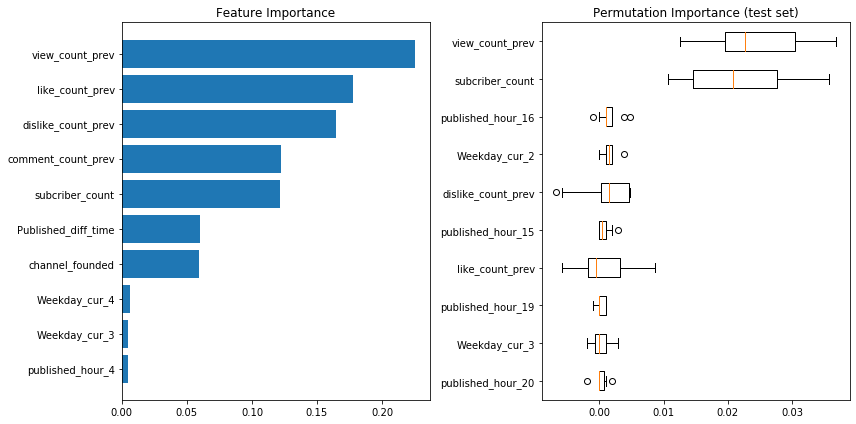

In [130]:
feature_importance = clf.feature_importances_
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
sorted_idx = np.argsort(feature_importance)
pos = np.arange(10) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx][-10:], align='center')
plt.yticks(pos, np.array(columns)[sorted_idx][-10:])
plt.title('Feature Importance')

result = permutation_importance(clf, val_boost, val_target, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(result.importances[sorted_idx][-10:].T,
            vert=False, labels=np.array(columns)[sorted_idx][-10:])
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

# Text,  numerical and categorical

In [58]:
train_boost = [train_numerical, train_categorical, train_text]
train_boost = np.concatenate(train_boost, axis = 1)
val_boost = [val_numerical, val_categorical, val_text]
val_boost = np.concatenate(val_boost, axis = 1)
test_boost = [test_numerical, test_categorical, text_test]
test_boost = np.concatenate(test_boost, axis = 1)

In [59]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

max_depths = [10, 20, 30, 40]
n_estimators = [100, 200, 300, 400, 600, 800, 1200]
min_samples_leaf = [1, 2, 4, 6]

val_metrics = []
test_metrics = []
for max_depth in max_depths:
    for n_estimator in n_estimators:
        for min_leaf in min_samples_leaf:
            clf = RandomForestClassifier(max_depth = max_depth, n_estimators = n_estimator, min_samples_leaf =min_leaf, n_jobs=-1, verbose = 1)
            print(clf)
            clf.fit(train_boost, train_target.ravel())
            res = clf.predict_proba(val_boost)
            acc = binary_acc(np.round(res[:,1]), val_target.squeeze().astype(int), 0.5)
            prec = precision_score(val_target.squeeze().astype(int), np.round(res[:,1]))
            rec = recall_score(val_target.squeeze().astype(int), np.round(res[:,1]))
            roc_auc = roc_auc_score(val_target.squeeze().astype(int), np.round(res[:,1]))
            val_metrics.append((acc, prec, rec, roc_auc))
            res = clf.predict_proba(test_boost)
            acc = binary_acc(np.round(res[:,1]), test_target.squeeze().astype(int), 0.5)
            prec = precision_score(test_target.squeeze().astype(int), np.round(res[:,1]))
            rec = recall_score(test_target.squeeze().astype(int), np.round(res[:,1]))
            roc_auc = roc_auc_score(test_target.squeeze().astype(int), np.round(res[:,1]))
            test_metrics.append((acc, prec, rec, roc_auc))
            

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.6s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.7s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.6s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.7s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    0.9s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    0.8s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    0.8s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 400 out of 400 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    0.8s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 400 out of 400 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=600,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed: 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=600,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed: 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=600,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed: 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=600,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed: 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    1.7s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed: 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    1.6s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed: 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    1.6s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed: 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    1.7s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed: 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:    2.5s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 1200 out of 1200 | elapsed:    0.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elaps

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:    2.5s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 1200 out of 1200 | elapsed:    0.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elaps

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:    2.4s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 1200 out of 1200 | elapsed:    0.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elaps

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:    2.5s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 1200 out of 1200 | elapsed:    0.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elaps

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.7s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.7s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.7s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.7s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    0.9s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 400 out of 400 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    0.9s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 400 out of 400 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    0.9s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 400 out of 400 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    0.9s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 400 out of 400 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=600,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed: 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=600,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed: 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=600,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed: 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=600,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed: 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    1.9s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed: 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    1.8s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed: 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    1.8s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed: 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    1.7s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed: 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:    2.7s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 1200 out of 1200 | elapsed:    0.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elaps

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:    2.8s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 1200 out of 1200 | elapsed:    0.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elaps

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:    2.6s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 1200 out of 1200 | elapsed:    0.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elaps

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:    2.6s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 1200 out of 1200 | elapsed:    0.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elaps

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.7s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.7s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.7s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.6s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    1.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 400 out of 400 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    1.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 400 out of 400 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    0.9s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 400 out of 400 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    0.9s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 400 out of 400 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=600,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.4s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed: 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=600,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.4s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed: 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=600,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.4s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed: 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=600,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed: 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    1.9s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed: 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    1.8s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed: 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    1.8s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed: 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    1.7s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed: 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:    2.7s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 1200 out of 1200 | elapsed:    0.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elaps

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:    2.7s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 1200 out of 1200 | elapsed:    0.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elaps

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:    2.7s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 1200 out of 1200 | elapsed:    0.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elaps

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:    2.7s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 1200 out of 1200 | elapsed:    0.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elaps

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=40, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=40, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=40, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=40, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=40, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=40, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=40, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=40, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=40, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.7s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=40, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.7s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=40, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.7s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=40, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.7s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=40, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    1.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 400 out of 400 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=40, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    0.9s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 400 out of 400 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=40, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    0.9s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 400 out of 400 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=40, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    0.9s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 400 out of 400 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=40, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=600,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.4s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed: 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=40, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=600,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.5s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed: 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=40, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=600,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.4s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed: 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=40, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=600,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed: 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=40, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    1.8s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed: 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=40, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    1.8s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed: 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=40, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    1.8s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed: 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=40, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    1.7s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed: 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=40, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:    2.8s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 1200 out of 1200 | elapsed:    0.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elaps

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=40, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:    2.8s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 1200 out of 1200 | elapsed:    0.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elaps

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=40, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:    2.6s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 1200 out of 1200 | elapsed:    0.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elaps

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=40, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:    2.6s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 1200 out of 1200 | elapsed:    0.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elaps

In [60]:
test_metrics = [list(elem) for elem in test_metrics]
val_metrics = [list(elem) for elem in val_metrics]

In [61]:
combs = []
for max_depth in max_depths:
    for n_estimator in n_estimators:
        for min_leaf in min_samples_leaf:
            combs.append([max_depth, n_estimator, min_leaf])

In [64]:
val_metrics = pd.DataFrame.from_records(val_metrics, columns = ['acc_val', 'prec_val', 'rec_val',  'roc_auc_val'])
test_metrics = pd.DataFrame.from_records(test_metrics, columns = ['acc_test', 'prec_test', 'rec_test',  'roc_auc_test'])

In [66]:
combs = pd.DataFrame.from_records(combs, columns = ['max_depth', 'n_estimators', 'min_leaf'])

In [67]:
randomfor_metrics = pd.concat([combs, val_metrics, test_metrics], axis=1, sort=False)

In [72]:
randomfor_metrics.sort_values(by = 'roc_auc_test',   ascending=False)

,max_depth,n_estimators,min_leaf,acc_val,prec_val,rec_val,roc_auc_val,acc_test,prec_test,rec_test,roc_auc_test
32,20,200,1,0.817215,0.622449,0.514768,0.710960,0.873552,0.639344,0.472727,0.711105
96,40,400,1,0.817215,0.627660,0.497890,0.705030,0.871622,0.629032,0.472727,0.709957
69,30,400,2,0.819149,0.634409,0.497890,0.706285,0.872587,0.636364,0.466667,0.708075
90,40,200,4,0.816248,0.627027,0.489451,0.701438,0.872587,0.638655,0.460606,0.705619
82,30,1200,4,0.815280,0.622340,0.493671,0.702293,0.870656,0.628099,0.460606,0.704471
...,...,...,...,...,...,...,...,...,...,...,...
15,10,400,6,0.815280,0.618557,0.506329,0.706740,0.863900,0.600000,0.436364,0.690627
89,40,200,2,0.815280,0.619792,0.502110,0.705258,0.863900,0.600000,0.436364,0.690627
28,20,100,1,0.820116,0.630769,0.518987,0.714324,0.862934,0.595041,0.436364,0.690053
63,30,200,6,0.810445,0.608466,0.485232,0.696192,0.865830,0.612069,0.430303,0.689319


In [68]:
randomfor_metrics = randomfor_metrics.sort_values(by=['roc_auc_test'], ascending = False)
randomfor_metrics.to_excel("random_for_num_categ_text.xlsx", index=False)

In [73]:
columns = ['channel_founded', 'subcriber_count', 'view_count_prev', 'like_count_prev','dislike_count_prev', 'comment_count_prev', 'Published_diff_time', 'published_hour_0', 'published_hour_1', 'published_hour_2',
       'published_hour_3', 'published_hour_4', 'published_hour_5',
       'published_hour_6', 'published_hour_7', 'published_hour_8',
       'published_hour_9', 'published_hour_10', 'published_hour_11',
       'published_hour_12', 'published_hour_13', 'published_hour_14',
       'published_hour_15', 'published_hour_16', 'published_hour_17',
       'published_hour_18', 'published_hour_19', 'published_hour_20',
       'published_hour_21', 'published_hour_22', 'published_hour_23',
       'Weekday_cur_0', 'Weekday_cur_1', 'Weekday_cur_2', 'Weekday_cur_3',
       'Weekday_cur_4', 'Weekday_cur_5', 'Weekday_cur_6']

In [74]:
for i in range(train_text.shape[1]):
    columns.append('text_' + str(i))

In [131]:
clf = RandomForestClassifier(max_depth = 20, n_estimators = 200, min_samples_leaf = 1,  n_jobs=-1, verbose = 1)
clf.fit(train_boost, train_target.ravel())

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.5s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)

[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished


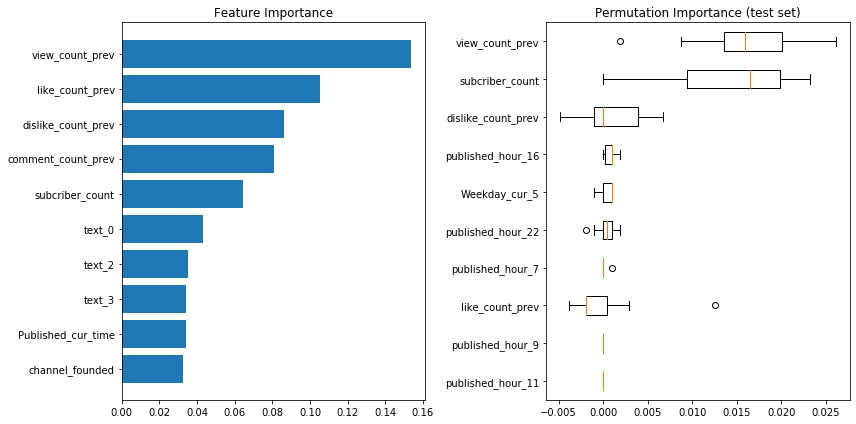

In [76]:
feature_importance = clf.feature_importances_
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
sorted_idx = np.argsort(feature_importance)
pos = np.arange(10) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx][-10:], align='center')
plt.yticks(pos, np.array(columns)[sorted_idx][-10:])
plt.title('Feature Importance')

result = permutation_importance(clf, val_boost, val_target, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(result.importances[sorted_idx][-10:].T,
            vert=False, labels=np.array(columns)[sorted_idx][-10:])
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

# Text+Visual+Text

In [141]:
train_numerical = train[['channel_founded', 'subcriber_count', 'view_count_prev', 'like_count_prev','dislike_count_prev', 'comment_count_prev', 'Published_diff_time', 'video_duration', 'video_popularity']].values
train_categorical = train[['published_hour_0', 'published_hour_1', 'published_hour_2',
       'published_hour_3', 'published_hour_4', 'published_hour_5',
       'published_hour_6', 'published_hour_7', 'published_hour_8',
       'published_hour_9', 'published_hour_10', 'published_hour_11',
       'published_hour_12', 'published_hour_13', 'published_hour_14',
       'published_hour_15', 'published_hour_16', 'published_hour_17',
       'published_hour_18', 'published_hour_19', 'published_hour_20',
       'published_hour_21', 'published_hour_22', 'published_hour_23',
       'Weekday_cur_0', 'Weekday_cur_1', 'Weekday_cur_2', 'Weekday_cur_3',
       'Weekday_cur_4', 'Weekday_cur_5', 'Weekday_cur_6']].values
train_target = train[['popular']].values

In [142]:
val_numerical = val[['channel_founded', 'subcriber_count', 'view_count_prev', 'like_count_prev','dislike_count_prev', 'comment_count_prev', 'Published_diff_time', 'video_duration', 'video_popularity']].values
val_categorical = val[['published_hour_0', 'published_hour_1', 'published_hour_2',
       'published_hour_3', 'published_hour_4', 'published_hour_5',
       'published_hour_6', 'published_hour_7', 'published_hour_8',
       'published_hour_9', 'published_hour_10', 'published_hour_11',
       'published_hour_12', 'published_hour_13', 'published_hour_14',
       'published_hour_15', 'published_hour_16', 'published_hour_17',
       'published_hour_18', 'published_hour_19', 'published_hour_20',
       'published_hour_21', 'published_hour_22', 'published_hour_23',
       'Weekday_cur_0', 'Weekday_cur_1', 'Weekday_cur_2', 'Weekday_cur_3',
       'Weekday_cur_4', 'Weekday_cur_5', 'Weekday_cur_6']].values
val_target = val[['popular']].values

In [143]:
test_numerical = test[['channel_founded', 'subcriber_count', 'view_count_prev', 'like_count_prev','dislike_count_prev', 'comment_count_prev', 'Published_diff_time', 'video_duration', 'video_popularity']].values
test_categorical = test[['published_hour_0', 'published_hour_1', 'published_hour_2',
       'published_hour_3', 'published_hour_4', 'published_hour_5',
       'published_hour_6', 'published_hour_7', 'published_hour_8',
       'published_hour_9', 'published_hour_10', 'published_hour_11',
       'published_hour_12', 'published_hour_13', 'published_hour_14',
       'published_hour_15', 'published_hour_16', 'published_hour_17',
       'published_hour_18', 'published_hour_19', 'published_hour_20',
       'published_hour_21', 'published_hour_22', 'published_hour_23',
       'Weekday_cur_0', 'Weekday_cur_1', 'Weekday_cur_2', 'Weekday_cur_3',
       'Weekday_cur_4', 'Weekday_cur_5', 'Weekday_cur_6']].values
test_target = test[['popular']].values

In [144]:
train_boost = [train_numerical, train_categorical, train_text]
train_boost = np.concatenate(train_boost, axis = 1)
val_boost = [val_numerical, val_categorical, val_text]
val_boost = np.concatenate(val_boost, axis = 1)
test_boost = [test_numerical, test_categorical, text_test]
test_boost = np.concatenate(test_boost, axis = 1)

In [92]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

max_depths = [10, 20, 30, 40]
n_estimators = [100, 200, 300, 400, 600, 800, 1200]
min_samples_leaf = [1, 2, 4, 6]

val_metrics = []
test_metrics = []
for max_depth in max_depths:
    for n_estimator in n_estimators:
        for min_leaf in min_samples_leaf:
            clf = RandomForestClassifier(max_depth = max_depth, n_estimators = n_estimator, min_samples_leaf =min_leaf, n_jobs=-1, verbose = 1)
            print(clf)
            clf.fit(train_boost, train_target.ravel())
            res = clf.predict_proba(val_boost)
            acc = binary_acc(np.round(res[:,1]), val_target.squeeze().astype(int), 0.5)
            prec = precision_score(val_target.squeeze().astype(int), np.round(res[:,1]))
            rec = recall_score(val_target.squeeze().astype(int), np.round(res[:,1]))
            roc_auc = roc_auc_score(val_target.squeeze().astype(int), np.round(res[:,1]))
            val_metrics.append((acc, prec, rec, roc_auc))
            res = clf.predict_proba(test_boost)
            acc = binary_acc(np.round(res[:,1]), test_target.squeeze().astype(int), 0.5)
            prec = precision_score(test_target.squeeze().astype(int), np.round(res[:,1]))
            rec = recall_score(test_target.squeeze().astype(int), np.round(res[:,1]))
            roc_auc = roc_auc_score(test_target.squeeze().astype(int), np.round(res[:,1]))
            test_metrics.append((acc, prec, rec, roc_auc))
            

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.7s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.7s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.7s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.6s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    0.9s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 400 out of 400 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    0.8s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 400 out of 400 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    0.9s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 400 out of 400 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    0.8s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 400 out of 400 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=600,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.4s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed: 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=600,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed: 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=600,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed: 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=600,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed: 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    1.7s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed: 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    1.7s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed: 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    1.6s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed: 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    1.7s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed: 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:    2.5s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 1200 out of 1200 | elapsed:    0.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elaps

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:    2.5s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 1200 out of 1200 | elapsed:    0.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elaps

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:    2.5s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 1200 out of 1200 | elapsed:    0.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elaps

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:    2.4s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 1200 out of 1200 | elapsed:    0.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elaps

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.7s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.7s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.7s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.7s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    0.9s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 400 out of 400 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    0.9s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 400 out of 400 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    0.9s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 400 out of 400 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    0.9s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 400 out of 400 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=600,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.4s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed: 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=600,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed: 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=600,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed: 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=600,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed: 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    1.8s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed: 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    1.8s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed: 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    1.7s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed: 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    1.8s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed: 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:    2.8s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 1200 out of 1200 | elapsed:    0.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elaps

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:    2.7s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 1200 out of 1200 | elapsed:    0.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elaps

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:    2.6s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 1200 out of 1200 | elapsed:    0.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elaps

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:    2.6s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 1200 out of 1200 | elapsed:    0.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elaps

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.7s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.7s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.7s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.6s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    0.9s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 400 out of 400 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    0.9s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 400 out of 400 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    0.9s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 400 out of 400 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    0.9s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 400 out of 400 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=600,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.5s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed: 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=600,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.4s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed: 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=600,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed: 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=600,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.4s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed: 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    1.8s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed: 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    1.9s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed: 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    1.7s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed: 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    1.7s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed: 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:    2.7s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 1200 out of 1200 | elapsed:    0.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elaps

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:    2.7s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 1200 out of 1200 | elapsed:    0.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elaps

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:    2.6s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 1200 out of 1200 | elapsed:    0.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elaps

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:    2.5s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 1200 out of 1200 | elapsed:    0.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elaps

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=40, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=40, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=40, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=40, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=40, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=40, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=40, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=40, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=40, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.7s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=40, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.7s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=40, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.7s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.2s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=40, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.6s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 300 out of 300 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=40, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    0.9s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 400 out of 400 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=40, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    0.9s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 400 out of 400 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=40, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    0.9s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 400 out of 400 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=40, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    0.9s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 400 out of 400 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=40, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=600,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.4s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed: 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=40, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=600,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.4s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed: 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=40, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=600,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.4s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed: 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=40, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=600,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.4s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 600 out of 600 | elapsed: 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=40, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    1.9s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed: 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=40, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    1.8s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed: 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=40, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    1.7s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed: 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=40, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    1.8s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed: 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=40, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:    2.7s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 1200 out of 1200 | elapsed:    0.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elaps

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=40, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:    2.7s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 1200 out of 1200 | elapsed:    0.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elaps

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=40, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:    2.6s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 1200 out of 1200 | elapsed:    0.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elaps

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=40, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:    2.7s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done 1200 out of 1200 | elapsed:    0.3s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elaps

In [93]:
test_metrics = [list(elem) for elem in test_metrics]
val_metrics = [list(elem) for elem in val_metrics]

In [94]:
combs = []
for max_depth in max_depths:
    for n_estimator in n_estimators:
        for min_leaf in min_samples_leaf:
            combs.append([max_depth, n_estimator, min_leaf])

In [95]:
val_metrics = pd.DataFrame.from_records(val_metrics, columns = ['acc_val', 'prec_val', 'rec_val',  'roc_auc_val'])
test_metrics = pd.DataFrame.from_records(test_metrics, columns = ['acc_test', 'prec_test', 'rec_test',  'roc_auc_test'])

In [96]:
combs = pd.DataFrame.from_records(combs, columns = ['max_depth', 'n_estimators', 'min_leaf'])

In [97]:
randomfor_metrics = pd.concat([combs, val_metrics, test_metrics], axis=1, sort=False)

In [98]:
randomfor_metrics.sort_values(by = 'roc_auc_test',   ascending=False)

,max_depth,n_estimators,min_leaf,acc_val,prec_val,rec_val,roc_auc_val,acc_test,prec_test,rec_test,roc_auc_test
60,30,200,1,0.827853,0.651282,0.535865,0.725273,0.870656,0.634783,0.442424,0.697102
86,40,100,4,0.829787,0.658031,0.535865,0.726527,0.869691,0.631579,0.436364,0.694072
101,40,600,2,0.820116,0.630769,0.518987,0.714324,0.867761,0.620690,0.436364,0.692923
107,40,800,6,0.820116,0.630769,0.518987,0.714324,0.866795,0.615385,0.436364,0.692349
30,20,100,4,0.823985,0.636816,0.540084,0.724245,0.866795,0.615385,0.436364,0.692349
...,...,...,...,...,...,...,...,...,...,...,...
1,10,100,2,0.823985,0.639594,0.531646,0.721281,0.861969,0.596491,0.412121,0.679654
64,30,300,1,0.833656,0.668394,0.544304,0.732001,0.865830,0.620370,0.406061,0.679494
9,10,300,2,0.822050,0.638743,0.514768,0.714097,0.864865,0.614679,0.406061,0.678920
104,40,800,1,0.829787,0.656410,0.540084,0.728010,0.863900,0.609091,0.406061,0.678346


In [99]:
randomfor_metrics = randomfor_metrics.sort_values(by=['roc_auc_test'], ascending = False)
randomfor_metrics.to_excel("random_for_num_categ_text_vis.xlsx", index=False)

In [138]:
clf = RandomForestClassifier(max_depth = 30, n_estimators = 200, min_samples_leaf = 1,  n_jobs=-1, verbose = 1)
clf.fit(train_boost, train_target.ravel())

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.5s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)

In [149]:
columns = ['channel_founded', 'subcriber_count', 'view_count_prev', 'like_count_prev','dislike_count_prev', 'comment_count_prev', 'Published_diff_time', 'video_duration', 'video_popularity',  'published_hour_0', 'published_hour_1', 'published_hour_2',
       'published_hour_3', 'published_hour_4', 'published_hour_5',
       'published_hour_6', 'published_hour_7', 'published_hour_8',
       'published_hour_9', 'published_hour_10', 'published_hour_11',
       'published_hour_12', 'published_hour_13', 'published_hour_14',
       'published_hour_15', 'published_hour_16', 'published_hour_17',
       'published_hour_18', 'published_hour_19', 'published_hour_20',
       'published_hour_21', 'published_hour_22', 'published_hour_23',
       'Weekday_cur_0', 'Weekday_cur_1', 'Weekday_cur_2', 'Weekday_cur_3',
       'Weekday_cur_4', 'Weekday_cur_5', 'Weekday_cur_6']

for i in range(train_text.shape[1]):
    columns.append('text_' + str(i))

[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.1s finished


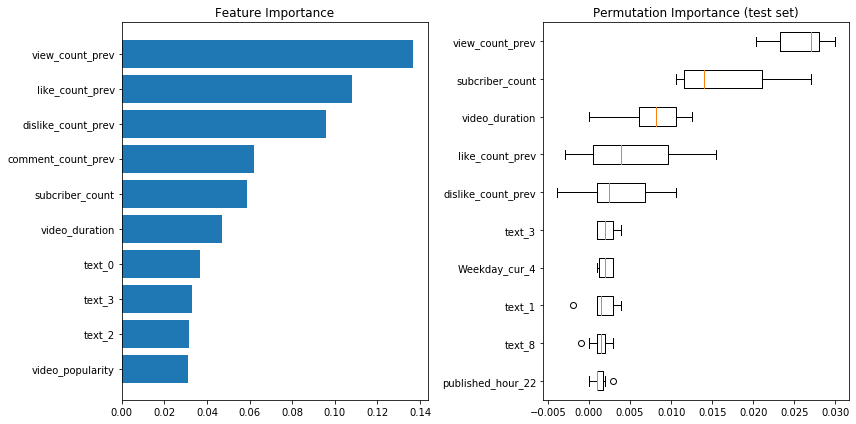

In [150]:
feature_importance = clf.feature_importances_
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
sorted_idx = np.argsort(feature_importance)
pos = np.arange(10) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx][-10:], align='center')
plt.yticks(pos, np.array(columns)[sorted_idx][-10:])
plt.title('Feature Importance')

result = permutation_importance(clf, val_boost, val_target, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(result.importances[sorted_idx][-10:].T,
            vert=False, labels=np.array(columns)[sorted_idx][-10:])
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()